<a href="https://colab.research.google.com/github/Amiya-Kalita/Machine-Learning/blob/main/Customer_sagmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1 : we import all the required libraries and load the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Scikit-learn imports
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [20]:
# Load dataset
csv_path = Path("/content/drive/MyDrive/DataSets/Mall_Customers.csv")
df_raw = pd.read_csv(csv_path)

In [6]:
# Quick checks values of the dataset
print("Shape:", df_raw.shape)
print("\nDtypes:\n", df_raw.dtypes)
print("\nMissing per column:\n", df_raw.isna().sum())
print("\nDuplicates:", int(df_raw.duplicated().sum()))

df_raw.head()

Shape: (200, 5)

Dtypes:
 CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Missing per column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Duplicates: 0


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Step 2 — Clean & preprocess column names

#### we clean the dataset — remove unnecessary ID columns, rename features for easier handling,
and create some simple  features (income_per_age, spend_per_age).

In [7]:
df = df_raw.copy()

# Clean column names
df.columns = (df.columns.str.strip().str.lower()
              .str.replace(" ", "_")
              .str.replace("(", "", regex=False)
              .str.replace(")", "", regex=False))

# Drop identifier column
df = df.drop(columns=["customerid"], errors="ignore")

In [8]:
# Rename for clarity
df = df.rename(columns={
    "annual_income_k$": "income_k",
    "spending_score_1-100": "spend_score"
})

# Feature engineering
df["income_per_age"] = df["income_k"] / df["age"].replace(0, np.nan)
df["spend_per_age"]  = df["spend_score"] / df["age"].replace(0, np.nan)

# Create age buckets (for profiling later)
age_bins = [0, 24, 34, 44, 54, 120]
age_labels = ["18–24", "25–34", "35–44", "45–54", "55+"]
df["age_bucket"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, include_lowest=True)

df.head()

,gender,age,income_k,spend_score,income_per_age,spend_per_age,age_bucket
0,Male,19,15,39,0.789474,2.052632,18–24
1,Male,21,15,81,0.714286,3.857143,18–24
2,Female,20,16,6,0.800000,0.300000,18–24
3,Female,23,16,77,0.695652,3.347826,18–24
4,Female,31,17,40,0.548387,1.290323,25–34


### Step 3 — Exploratory Data Analysis (EDA)

##### visualize distributions for numeric features and the gender balance to get a sense of the data.

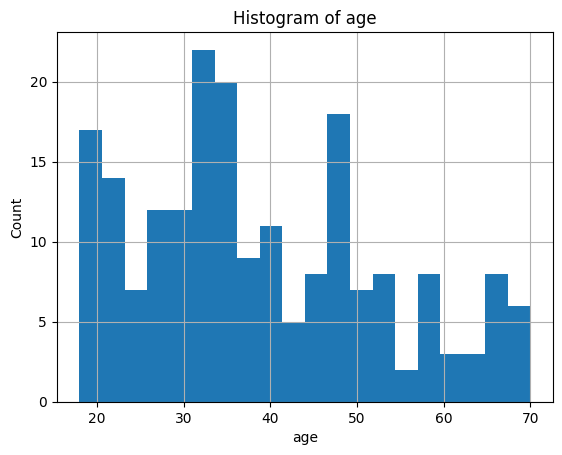

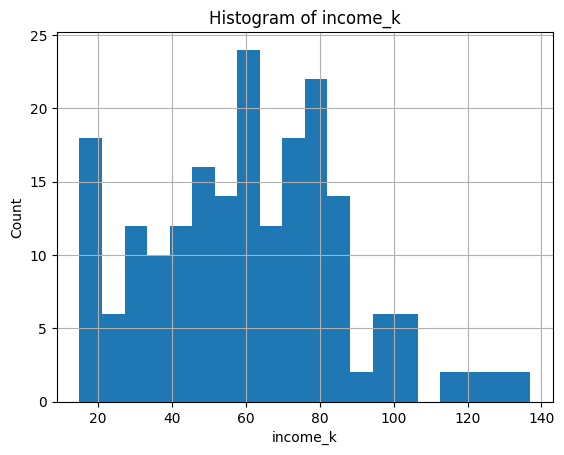

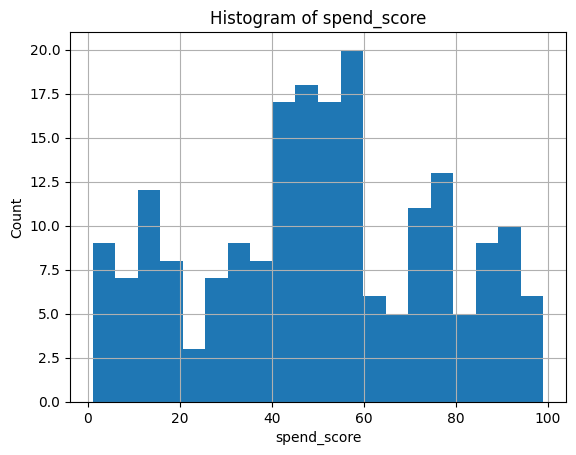

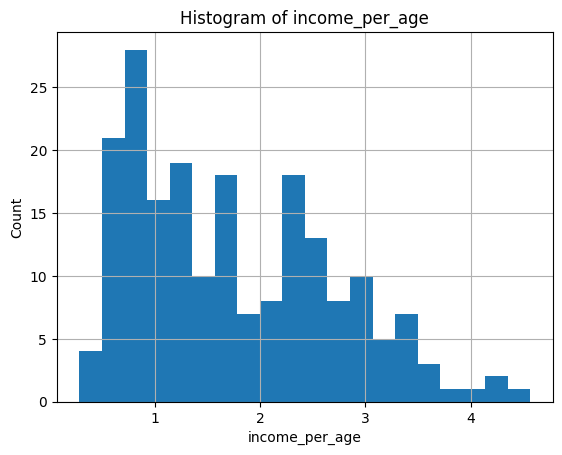

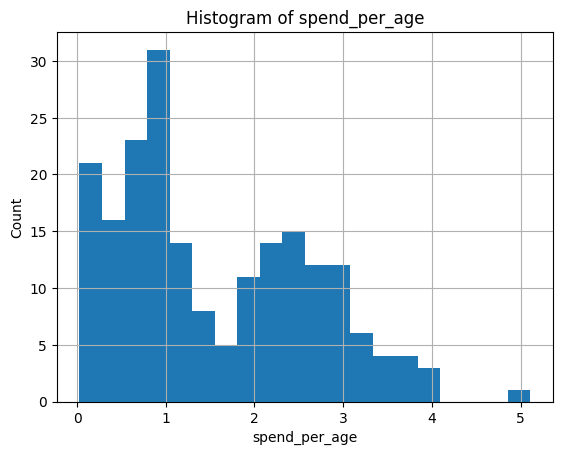

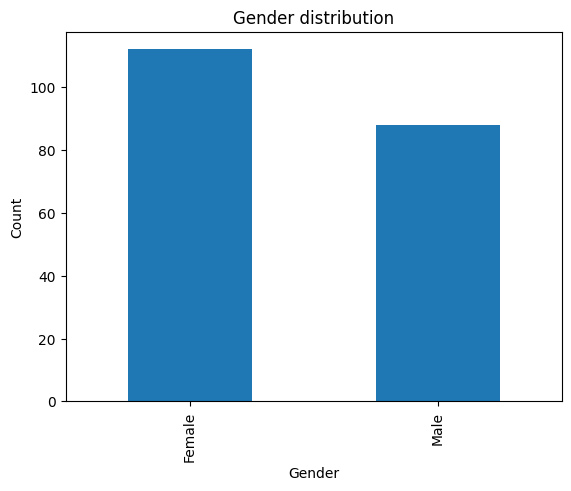

In [9]:
num_cols = ["age", "income_k", "spend_score", "income_per_age", "spend_per_age"]

for col in num_cols:
    plt.figure()
    df[col].hist(bins=20)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Histogram of {col}")
    plt.show()

# Gender distribution
plt.figure()
df["gender"].value_counts().plot(kind="bar")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender distribution")
plt.show()

### Step 4 — Data Preprocessing Pipeline

 using a scikit-learn ColumnTransformer pipeline that:

imputes missing values

scales numeric data using RobustScaler (resists outliers)

one-hot encodes categorical variables (like Gender)

In [11]:
numeric_features = ["age", "income_k", "spend_score", "income_per_age", "spend_per_age"]
categorical_features = ["gender"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Apply preprocessing
X = preprocessor.fit_transform(df[numeric_features + categorical_features])

# Extract feature names
ohe = preprocessor.named_transformers_["cat"]["onehot"]
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

pd.DataFrame(X, columns=feature_names).head()

,age,income_k,spend_score,income_per_age,spend_per_age,gender_Female,gender_Male
0,-0.839506,-1.273973,-0.287582,-0.502540,0.515050,0.0,1.0
1,-0.740741,-1.273973,0.810458,-0.550349,1.568393,0.0,1.0
2,-0.790123,-1.246575,-1.150327,-0.495847,-0.508009,1.0,0.0
3,-0.641975,-1.246575,0.705882,-0.562197,1.271091,1.0,0.0
4,-0.246914,-1.219178,-0.261438,-0.655838,0.070070,1.0,0.0


### Step 5 — Optimal Cluster Number (Elbow + Metrics)

Instead of guessing the number of clusters, we use multiple metrics:

Elbow (WCSS)

Silhouette Score

Davies-Bouldin Index

Calinski-Harabasz Index

In [12]:
inertias, sil_scores, db_scores, ch_scores = [], [], [], []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))
    db_scores.append(davies_bouldin_score(X, labels))
    ch_scores.append(calinski_harabasz_score(X, labels))

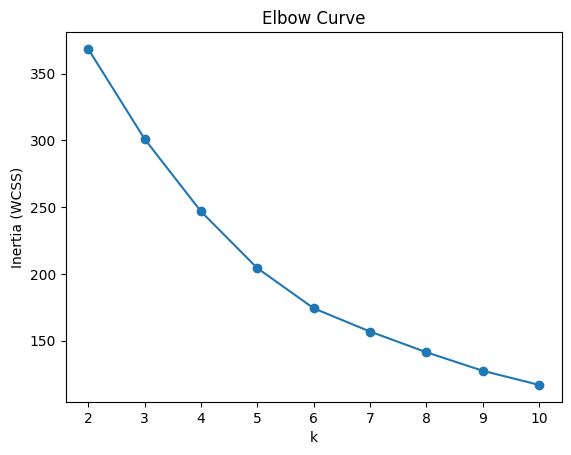

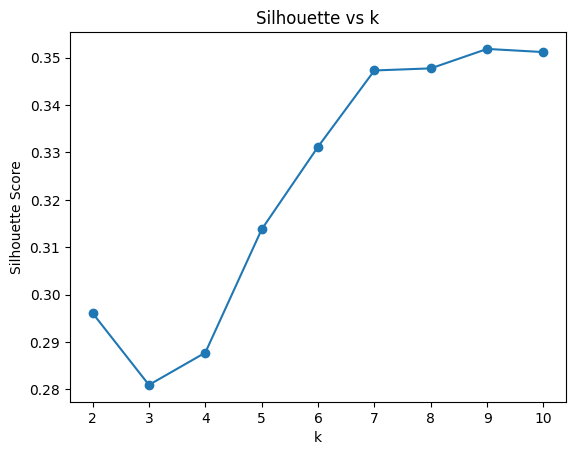

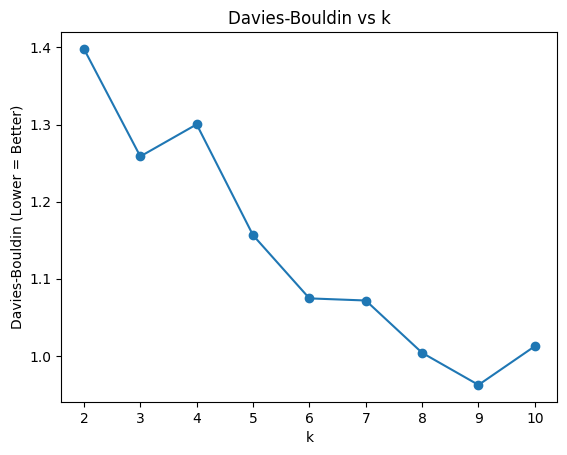

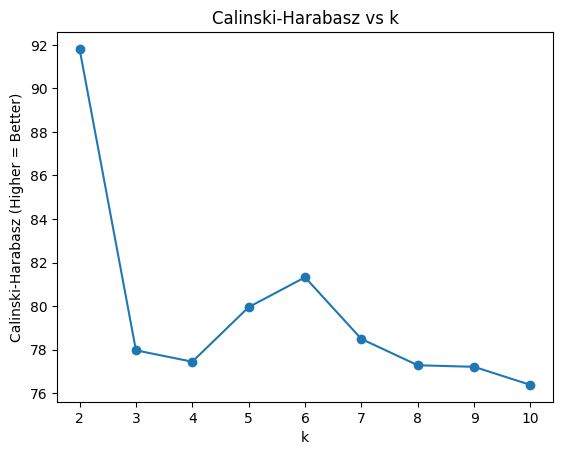

In [13]:
# Ploting all metrics
plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Curve"); plt.show()

plt.figure()
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("k"); plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k"); plt.show()

plt.figure()
plt.plot(k_values, db_scores, marker='o')
plt.xlabel("k"); plt.ylabel("Davies-Bouldin (Lower = Better)")
plt.title("Davies-Bouldin vs k"); plt.show()

plt.figure()
plt.plot(k_values, ch_scores, marker='o')
plt.xlabel("k"); plt.ylabel("Calinski-Harabasz (Higher = Better)")
plt.title("Calinski-Harabasz vs k"); plt.show()

### Step 6 — Build Clustering Models (KMeans, GMM, DBSCAN)

We test three clustering algorithms:

KMeans (centroid-based)

Gaussian Mixture (GMM) (probabilistic)

DBSCAN (density-based, no fixed k)**bold text**

In [14]:
k_opt = 6  # based on visual analysis

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=25)
labels_km = kmeans.fit_predict(X)

gmm = GaussianMixture(n_components=k_opt, covariance_type="full", random_state=42)
labels_gmm = gmm.fit_predict(X)

dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_db = dbscan.fit_predict(X)

In [15]:
def safe_scores(X, labels):
    unique = np.unique(labels)
    if len(unique) <= 1 or (len(unique) == 1 and unique[0] == -1):
        return {"silhouette": np.nan, "davies_bouldin": np.nan, "calinski_harabasz": np.nan}
    return {
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels)
    }

scores = {
    "KMeans_k6": safe_scores(X, labels_km),
    "GMM_k6": safe_scores(X, labels_gmm),
    "DBSCAN": safe_scores(X, labels_db)
}

scores

{'KMeans_k6': {'silhouette': np.float64(0.32949865718094806),
  'davies_bouldin': np.float64(1.0785293229882305),
  'calinski_harabasz': np.float64(81.4352902255727)},
 'GMM_k6': {'silhouette': np.float64(0.2896031751866764),
  'davies_bouldin': np.float64(1.1749835401531652),
  'calinski_harabasz': np.float64(66.26207749130158)},
 'DBSCAN': {'silhouette': nan,
  'davies_bouldin': nan,
  'calinski_harabasz': nan}}

### Step 7 — Visualize Clusters with PCA

We reduce the dataset to 2 dimensions using PCA to visualize the clusters for all three algorithms.

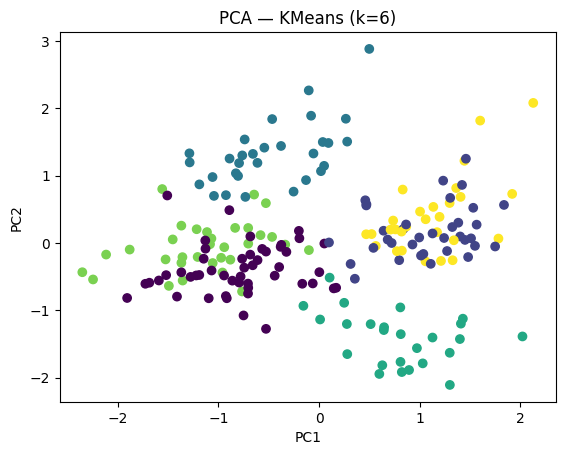

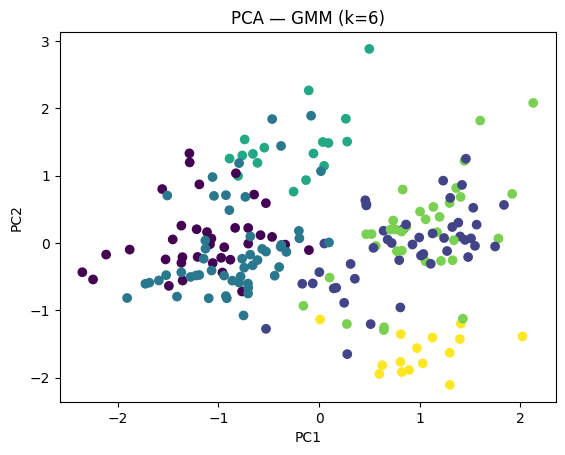

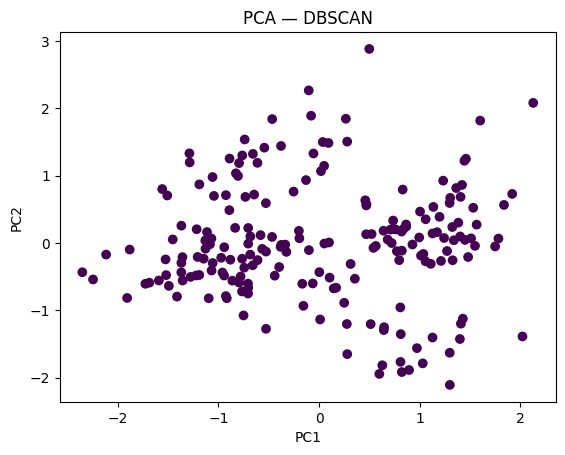

In [16]:
# PCA Visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

def plot_clusters(X2, labels, title):
    plt.figure()
    plt.scatter(X2[:, 0], X2[:, 1], c=labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.show()

plot_clusters(X_2d, labels_km, "PCA — KMeans (k=6)")
plot_clusters(X_2d, labels_gmm, "PCA — GMM (k=6)")
plot_clusters(X_2d, labels_db, "PCA — DBSCAN")

### Step 8 — Cluster Profiling

we attach cluster labels to the original data and calculate mean feature values per cluster.
This gives insight into each segment’s behavior.

In [17]:
# Step 8 — Cluster profiling
df_result = df.copy()
df_result["cluster_km"] = labels_km
df_result["cluster_gmm"] = labels_gmm
df_result["cluster_db"] = labels_db

profile_km = df_result.groupby("cluster_km")[["age", "income_k", "spend_score", "income_per_age", "spend_per_age"]].mean().round(2)
profile_km

,age,income_k,spend_score,income_per_age,spend_per_age
cluster_km,,,,,
0,47.00,46.78,39.65,1.03,0.88
1,29.06,76.11,67.67,2.66,2.34
2,39.87,90.50,16.10,2.44,0.41
3,25.56,26.48,76.24,1.07,3.10
4,55.34,48.94,39.31,0.91,0.73
5,29.11,76.32,71.93,2.69,2.50


### Step 9 — Visualize Cluster Profiles

visualize cluster sizes and the relationship between mean income and spending per cluster.

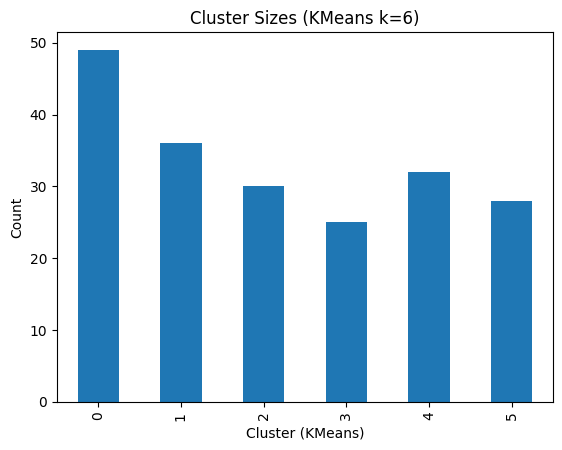

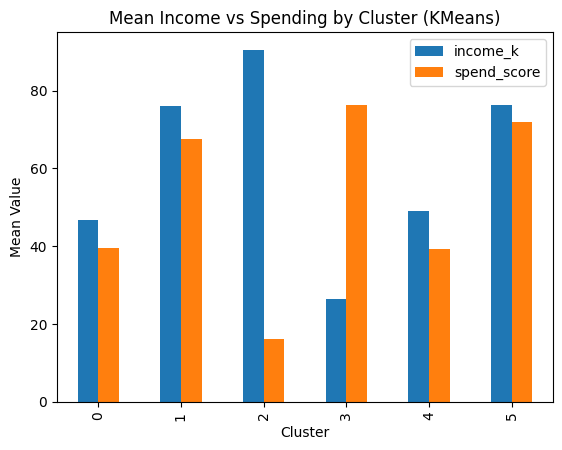

In [18]:
# Cluster size
df_result["cluster_km"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Cluster (KMeans)")
plt.ylabel("Count")
plt.title("Cluster Sizes (KMeans k=6)")
plt.show()

# Mean income vs spending
profile_km[["income_k", "spend_score"]].plot(kind="bar")
plt.title("Mean Income vs Spending by Cluster (KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.show()

### Step 10 — Export Results

we export the full clustered dataset and the cluster profile summary to CSV files.

In [19]:
# Step 10 — Save results
from pathlib import Path

output_dir = Path("/content/drive/MyDrive/Models")
output_dir.mkdir(parents=True, exist_ok=True)

df_result.to_csv(output_dir / "mall_customers_clustered.csv", index=False)
profile_km.to_csv(output_dir / "cluster_profile_kmeans.csv")

print("Files saved:")
print(f"- {output_dir / 'mall_customers_clustered.csv'}")
print(f"- {output_dir / 'cluster_profile_kmeans.csv'}")

Files saved:
- /content/drive/MyDrive/Models/mall_customers_clustered.csv
- /content/drive/MyDrive/Models/cluster_profile_kmeans.csv
